# Thesis Data Analysis — Reconciling Tilt Estimates from Mapping and Modelling

## Setup

Import modules.

In [1]:
# read .csv
from svglib.svglib import svg2rlg

# computation & data structures
import numpy as np
from math import *
import itertools
import pandas as pd
import glob

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.graphics import renderPDF
import os
import shutil

## Map Output Analysis

This cell handles the GIS output. Most of the attributes have already been calculated, so the main purpose of this code is to examine subsets of the data (center points, sample locations, distances) and evaluate each inflation center by a few different criteria (fraction of data explainable, fraction explainable within certain tilt constraints, etc.). I will eventually export a new table with these criteria for exporting back into GIS and exploring where those best candidates actually end up. And of course I explore everything though plotting here as well.

In [43]:
# location to read .csv files
map_data_location = "../GEOL192-GIS/data/"

# define a function for reading output .csv files (attribute tables in GIS) 
def map_data_from_csv(feature, num):
    return pd.read_csv(f"{map_data_location}{feature}_{str(num)}.csv")

# find all the .csv files in location 
flow_filenames = glob.glob(map_data_location + "flow*.csv")
channel_filenames = glob.glob(map_data_location + "channel*.csv")

# get list of # values from files of the form "*_#.csv". These two should be the same 
flow_center_IDs = [int(name.split('_')[1].split('.')[0]) for name in flow_filenames]
channel_center_IDs = [int(name.split('_')[1].split('.')[0]) for name in channel_filenames]

In this cell I define variables relevant to the specific geometry in question.

In [62]:
# list of populations for analysis. this is taken from the OBJECTID field of the Flowpaths polyline layer from which points were sampled
flow_populations = {
    'FL_SE': [49, 60, 61, 62, 63, 64, 85, 86, 87],
    'FL_ALL': list(range(100))
}

# fill this in with correct ID field inherited from channels
channel_populations = {
    'CH_ALL': list(range(500))
}

populations = [('flow', pop) for pop in flow_populations.items()] + [('channel', pop) for pop in channel_populations.items()]

# maximum realistic tilt value in degrees (positive value here)
MAX_TILT = 5

In [63]:
# object that stores data associated with a single inflation center analysis
class Center():
    def __init__(self, center_ID, feature, population: tuple = None):
        self.ID = center_ID
        self.data = map_data_from_csv(feature, center_ID)

        self.data['BETA1'] = self.data.apply(lambda row: degrees(acos(cos(radians(row['AZ1'] - (90 - row['THETA']))))), axis=1)

        # take only a population of points if desired
        if population is not None:
            self.pop_name, self.pop_list = population # unpack tuple
            self.data = self.data.loc[self.data['ORIG_FID'].isin(self.pop_list)]

        self.data_realistic_inflation = self.data[np.abs(self.data['TILT']) < MAX_TILT]

        # correct distances to km and add other key attributes to object
        self.dist = self.data['DIST'] / 1000
        self.tilt = self.data['TILT']
        self.beta1 = self.data['BETA1']

        # correct distances to km and add other key attributes to object
        self.dist_realistic = self.data_realistic_inflation['DIST'] / 1000
        self.tilt_realistic = self.data_realistic_inflation['TILT']

        # inflation center and paleo summit criteria. this can be updated with new criteria as new needed and will be automatically added to the output table for rejoining with the inflation center feature class
        if len(self.data) > 0:
            self.criteria = {
                'ID': self.ID,
                f'frac_possible_{self.pop_name}': self.data['TILT'].notnull().sum() / len(self.data),
                f'frac_realistic_{self.pop_name}': self.data_realistic_inflation['TILT'].notnull().sum() / len(self.data),
                f'summit_score_{self.pop_name}': np.mean(np.abs(self.data['BETA1'])),
                # f'mean_{self.pop_name}': self.data['TILT'][self.data['TILT'].notnull()].mean(),
                # f'std_{self.pop_name}': self.data['TILT'][self.data['TILT'].notnull()].std()
            }
        else:
            self.criteria = {
                'ID':self.ID,
                f'frac_possible_{self.pop_name}': np.nan,
                f'frac_realistic_{self.pop_name}': np.nan
            }

This cell makes a single table with the performance of each inflation center on each of the criteria and each of the sample populations. 

In [65]:
# this is a 2D array. the outer list is of each center point. each element of the outer list is an inner list. each element of an inner list is an InflationCenter object for one of the feature sub-populations
data_array = [
    [Center(ID, *pop) for pop in populations] for ID in flow_center_IDs
]

# initialize list
centers = []

# begin iteration through 2D array. first deal with the outer list: each element is specific to one inflation center point
for center in data_array:
    # initialize dict of criteria (and center ID)
    attributes_of_this_center = {}
    # iterate through inner list: each element is specific to one sample population
    for population in center:
        # add any unique entries (ID is in all but will only be added once) to this center-specific dict initialized just above this inner for loop
        attributes_of_this_center.update(population.criteria)
    # append the center-specific dict (now filled with criteria for all populations) to the main list
    centers.append(attributes_of_this_center)

# turn the list of dicts into a dataframe which can be easily exported as a .csv
centers_eval = pd.DataFrame(centers)


# little hack for weighted averages treating the flow and channel datasets as a single dataset
num_channel_samples = 401
num_flow_samples = 167
num_samples = num_channel_samples + num_flow_samples

flow_weight = num_flow_samples / num_samples
channel_weight = num_channel_samples / num_samples

centers_eval['summit_score_combined'] = centers_eval.apply(lambda row: flow_weight * row['summit_score_FL_ALL'] + channel_weight * row['summit_score_CH_ALL'], axis=1)

# is this normalization the same as the one right above? check the algebra because it seems to give the same numbers
centers_eval['frac_possible_combined'] = centers_eval.apply(lambda row: (num_flow_samples * row['frac_possible_FL_ALL'] + num_channel_samples * row['frac_possible_CH_ALL']) / (num_samples), axis=1)
centers_eval['frac_realistic_combined'] = centers_eval.apply(lambda row: (num_flow_samples * row['frac_realistic_FL_ALL'] + num_channel_samples * row['frac_realistic_CH_ALL']) / (num_samples), axis=1)

centers_eval.to_csv('centers_eval.csv')

In [61]:
centers_eval[centers_eval['ID'] == 478]

,ID,frac_possible_FL_SE,frac_realistic_FL_SE,summit_score_FL_SE,frac_possible_FL_ALL,frac_realistic_FL_ALL,summit_score_FL_ALL,frac_possible_CH_ALL,frac_realistic_CH_ALL,summit_score_CH_ALL,summit_score_combined
563,478,0.428571,0.071429,5.778119,0.377246,0.101796,7.98555,0.304239,0.092269,10.486241,9.751003


In [56]:
# sns.histplot(data=data_array[0][0].data['BETA1'])
data_array[0][2].data['BETA1']

0      40.566298
1      39.281718
2      38.105548
3      49.981504
4      36.164199
         ...    
396    45.406162
397    66.610220
398    31.344488
399    30.542107
400    29.634609
Name: BETA1, Length: 401, dtype: float64

## Model Output Analysis

Then, I define functions for reading the starting positions and displacements (radial and vertical components) of mesh vertices as expressed in the COMSOL files.

In [120]:
model_data_location = "../GEOL192-Model/data/"

def model_pos1_from_csv(string):
    r = np.genfromtxt(model_data_location + "r_" + string, delimiter= ",")[:,0]
    z = np.zeros(len(r)) # FIXME
    return np.array([r, z]).T

def model_disp_from_csv(string):
    r = np.genfromtxt(model_data_location + "r_" + string, delimiter= ",")[:,1]
    z = np.genfromtxt(model_data_location + "z_" + string, delimiter= ",")[:,1]
    return np.array([r, z]).T

I define physical constants used in the model here:

In [121]:
# constants in SI units
SHEAR_MODULUS = 2.4e10
ROCK_DENSITY = 2700
MAGMA_DENSITY = 2700
MARS_GRAVITY = 3.72
PLOT_WIDTH = 100_000


I include functions for displacement and angular tilt from an analytical solution which assumes a elastic half-space inflated by a spherical reservoir, for comparison.

In [122]:
def mogi_disp(overpressure, reservoir_radius, depth_to_center, radial_distance):
    d = depth_to_center
    r = radial_distance
    common_term = 3 * reservoir_radius**3 * overpressure / (4 * SHEAR_MODULUS * (d**2 + r**2)**1.5)
    disp_r = common_term * r
    disp_z = common_term * d
    return np.array(disp_r, disp_z)

def mogi_tilt(overpressure, reservoir_radius, depth_to_center, radial_distance):
    '''analytical check for spherical reservoir in elastic half-space. Confirms numerical model accuracy and that the olympus mons edifice geometry is not very important, at least for horizontal treatment'''
    a = 3 * reservoir_radius**3 * overpressure / (4 * SHEAR_MODULUS)
    d = depth_to_center
    r = radial_distance
    numerator = 3 * a * d * r
    denominator = (d**2 + r**2)**2.5 + a * d**2 - 2 * a * r**2
    return degrees(atan2(numerator, denominator))

Then I define classes for displaced vertices and surface elements (the latter defined by a consecutive pair of the former). These classes are primarily used to handle the radial tilt calculation.

In [123]:
class Vertex():
    def __init__(self, pos1, disp):
        self.pos1 = pos1
        self.disp = disp
        self.pos2 = self.pos1 + self.disp

class Element():
    def __init__(self, proximal_vertex, distal_vertex):

        # relative dimensions [r, z] of initial and displaced segments
        self.shape1 = distal_vertex.pos1 - proximal_vertex.pos1
        self.shape2 = distal_vertex.pos2 - proximal_vertex.pos2

        # mean position of initial and displaced segments
        self.pos1 = (distal_vertex.pos1 + proximal_vertex.pos1) / 2
        self.pos2 = (distal_vertex.pos2 + proximal_vertex.pos2) / 2

        # radial distances for plotting
        self.r1_km = self.pos1[0] / 1000
        self.r2_km = self.pos2[0] / 1000

        # initial and displaced slopes (positive downward from center)
        # index [1] is z component; [0] is r component
        self.slope1 = degrees(atan2(-self.shape1[1], self.shape1[0]))
        self.slope2 = degrees(atan2(-self.shape2[1], self.shape2[0]))

        self.tilt = self.slope2 - self.slope1


Finally, a model class is initialized by a combination of parameters (geometry, overpressure) which reads the relevant .csv files, builds the vertices and elements, and converts the element attributes (position, displacement, tilt) into lists for plotting or further analysis.

In [124]:
class Model():
    def __init__(self, depth_to_top, horizontal_radius, vertical_radius, mult):

        self.params = {
            "DtT": depth_to_top,
            "Ra": horizontal_radius,
            "Rb": vertical_radius,
            "mult": mult
        }

        self.overpressure = mult * depth_to_top * ROCK_DENSITY * MARS_GRAVITY

        filename = f"DtT_{depth_to_top}_Ra_{horizontal_radius}_Rb_{vertical_radius}_mult_{mult}_gmult_0.csv"

        # read initial positions and displacements
        self.pos1 = model_pos1_from_csv(filename)
        self.disp = model_disp_from_csv(filename)

        # build vertices from pos1 and disp if pos1 within defined length
        self.num_vertices = next(i for i, val in enumerate(self.pos1) if val[0] > PLOT_WIDTH)
        self.vertices = [Vertex(self.pos1[i], self.disp[i]) for i in range(self.num_vertices)]

        # build elements from consecutive vertex pairs
        self.vertex_pairs = zip(self.vertices[:-1], self.vertices[1:])
        self.elements = [Element(*pair) for pair in self.vertex_pairs]

        # put element attributes into dict of lists
        self.attributes = pd.DataFrame([vars(element) for element in self.elements]).to_dict("list")

# Model Output Analysis

I define the model parameter combinations used in COMSOL and build a Model class (defined above) from each geometry. Any subset of geometries can be used by removing elements from the parameter sets.

In [125]:
# parameter sweep in SI units
param_sweep = {
    "DtT": [10_000],
    "Ra": [50_000],
    "Rb": [10_000],
    "mult": [.8, .4, -.4, -.8]
}

# parameters which are constant for all models (just one value given above) will be listed in the figure title
constant_params = {key:val[0] for key, val in param_sweep.items() if len(val) == 1}
# parameters which vary for each model will be labeled accordingly
variable_params = [key for key, val in param_sweep.items() if len(val) > 1]

# build model object from all parameter combinations
geometries = itertools.product(*param_sweep.values())
models = [Model(*geometry) for geometry in geometries]

# Plotting

Finally, I plot numerical model outputs:

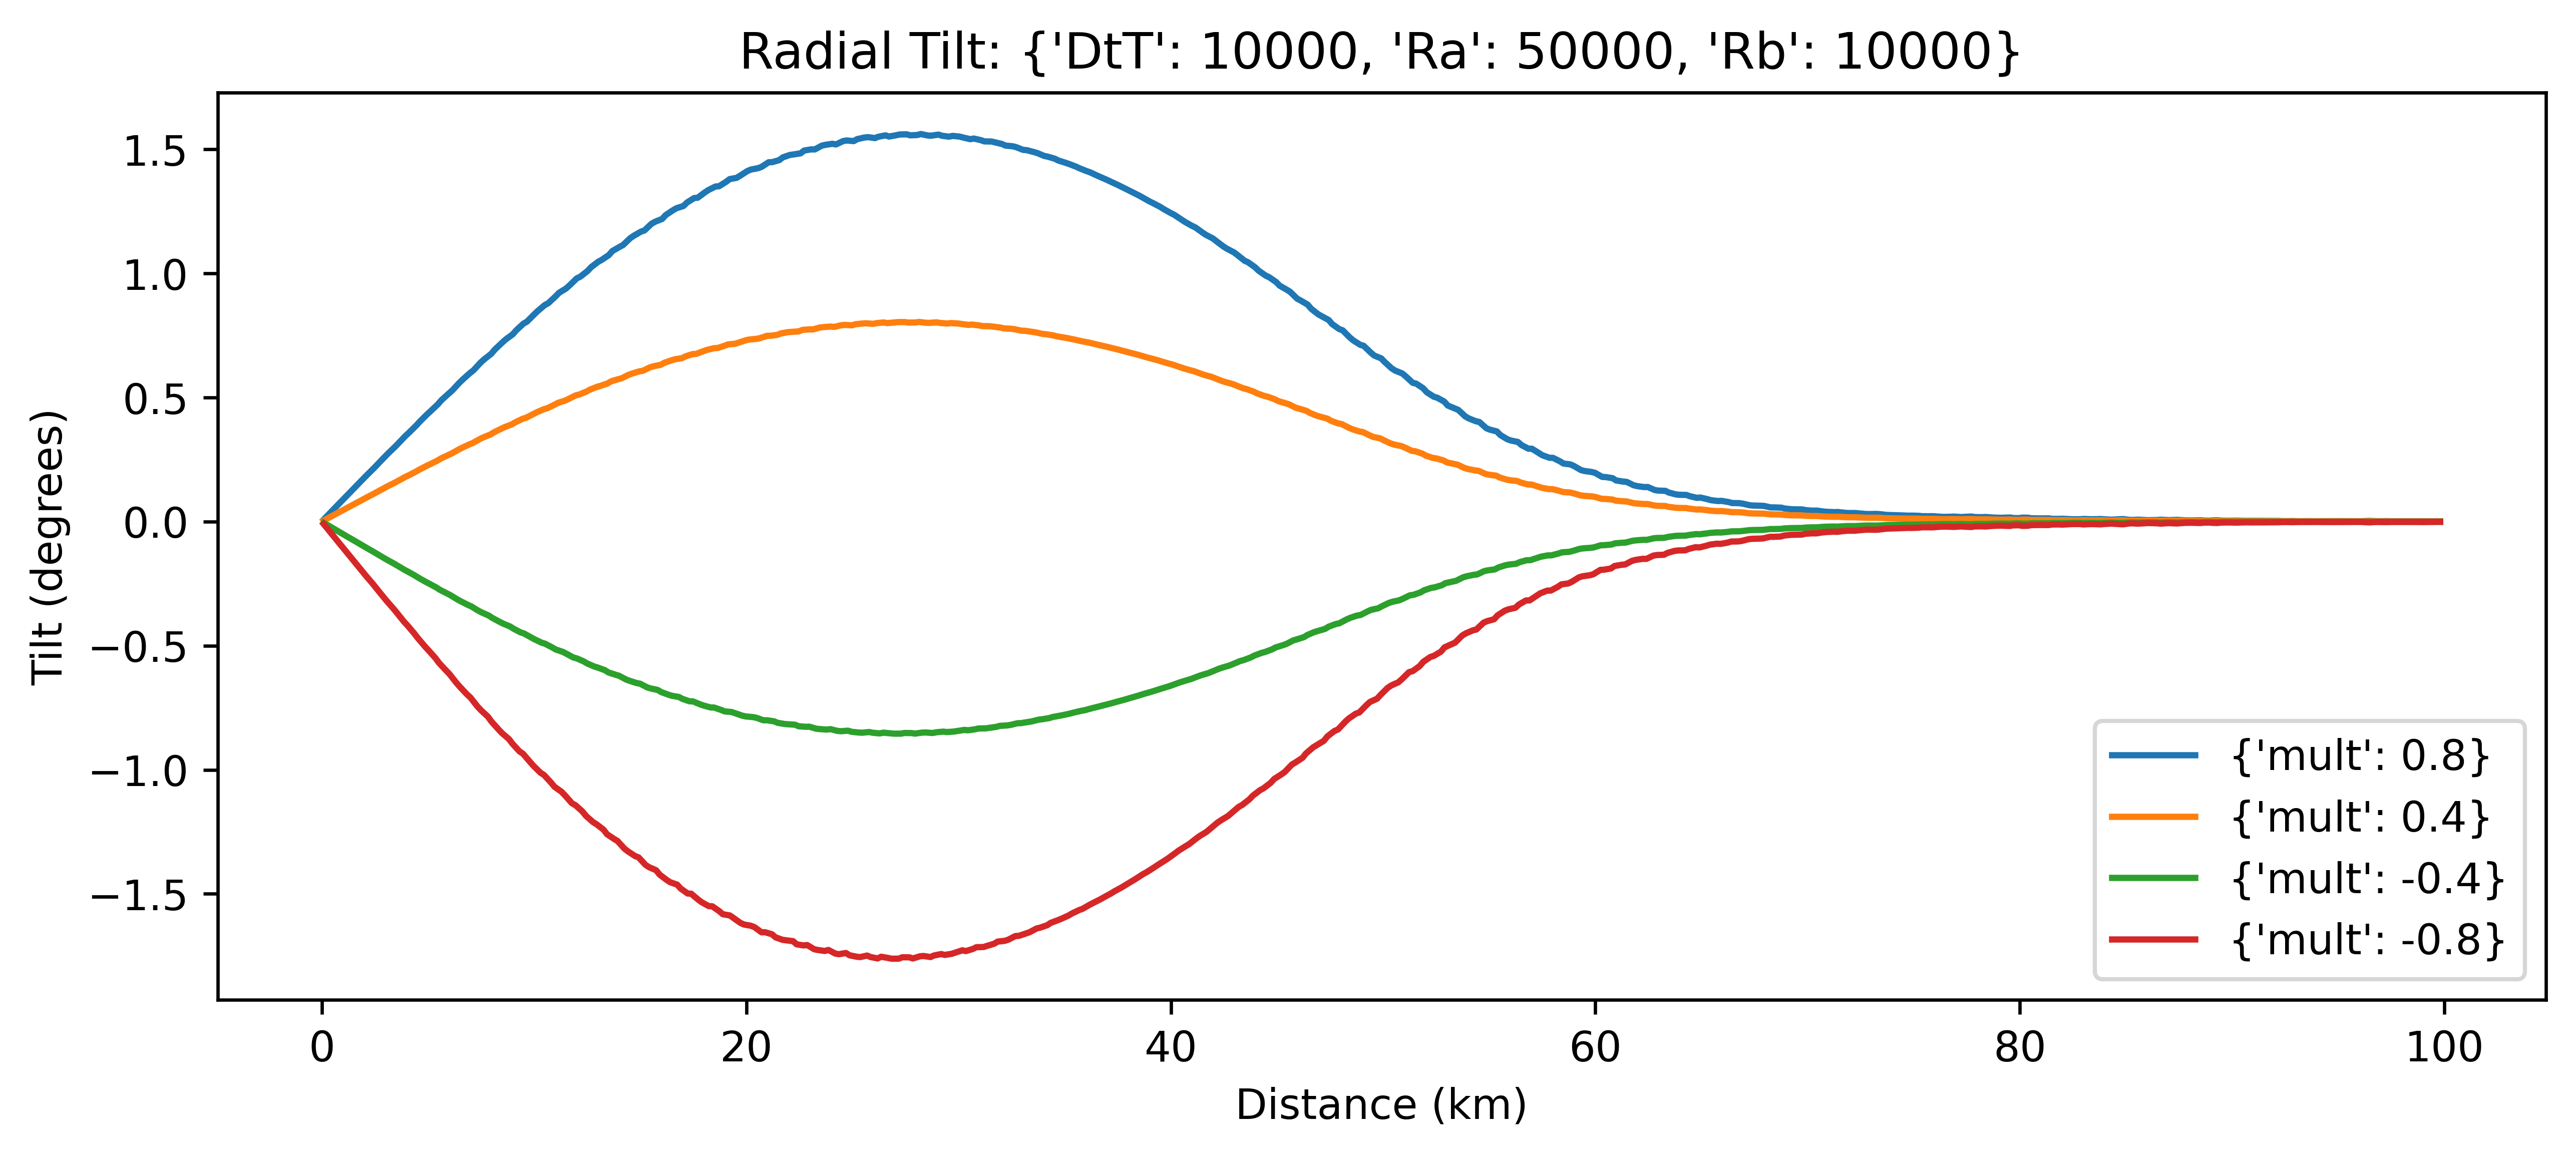

In [127]:
# plot figure
fig = plt.figure(figsize = (10, 4), dpi = 600)

# plot model data
for model in models:
    sns.lineplot(data=model.attributes, y="tilt", x = "r2_km", label={param:model.params[param] for param in variable_params})

plt.title(f"Radial Tilt: {constant_params}")
plt.xlabel("Distance (km)")
plt.ylabel("Tilt (degrees)")
plt.legend(loc="lower right")

# save as .svg
# fig.savefig("figures/plot.svg")

# .svg to .pdf 
# renderPDF.drawToFile(svg2rlg("plot.svg"), "plot.pdf")
# os.remove("figures/plot.svg")